<a href="https://colab.research.google.com/github/jcvdm01/machine-and-deep-learning/blob/main/Week%202/TMDL_2024_25_Assignment_2%2C_Qs_only_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Turing Machine and Deep Learning

## Assignment 2: Supervised Classification Problems

This notebook is meant for you to review and reflect on the content of Lecture 2, which was mainly about supervised learning problems in the general context of classification. We will reflect mainly on model and hyperparameter selection over the models we have discussed during the lecture: logistic regression, decision trees, random forests and support vector machines. This notebook should not be too much quantitative work (lines of code) but keep in mind that running this notebook may take a longer time than you may be used to for python programs (*training good models take time!*)

### Handing in your Assignment

Git is an invaluable resource to researchers and developers, and thus for this course, all course material will be (additionally) shared on GitHub. Though there is a tiny bit of a learning curve, this is worth the effort. To hand in your assignment (applicable to all weeks):

1. Create a folder called "Week 2" and copy this notebook and any other files or data that may be needed.
2. Finish the notebook and commit and push regularly. Your final commit before the deadline will be graded.


# Question 1 -- Classification Metrics

To contextualise, we learnt of 4 metrics in class: accuracy, precision, recall and F1 score. Answer the following text questions in the following markdown cell.
1. For accuracy, precision and recall, mention one specific example *each* (i.e. a well-defined problem where ML can be used) where they would be preferable.
2. For accuracy, precision and recall, mention one specific example *each* (i.e. a well-defined problem where ML can be used) where they would fail.
3. In which situations would the F1 score be helpful? Give one concrete example.



1. Accuracy: Predicting email spam detection, where spam and non-spam emails are roughly balanced in the dataset. Accuracy provides a quick measure of overall correctness.

Precision: Identifying fraudulent credit card transactions, where incorrectly labeling a transaction as fraudulent (false positives) can inconvenience customers. Precision reduces false positives, ensuring alerts have high reliability.

Recall: Diagnosing cancer patients from medical images, where missing a positive case (false negatives) can be life-threatening. Recall ensures that nearly all positive cases are identified.

2. Accuracy: Identifying rare diseases, where less than 1% of the population has the disease. High accuracy (99%) could be achieved simply by classifying everyone as healthy, but this misses every true positive case.

Precision: Airport security screening systems. Focusing solely on precision could reduce false alarms but risks missing actual threats (false negatives), which can be dangerous.

Recall: Recommendation systems for online shopping. Aiming only for high recall might recommend many irrelevant products to customers, making recommendations impractical and annoying.

3. Scenarios where precision and recall are equally important and there is an imbalance between classes. For example, in of customer reviews, businesses want to identify as many negative reviews as possible (high recall) while ensuring that identified negative reviews are genuinely negative (high precision). The F1 score balances these goals effectively, making it a suitable metric.


## Question 2 -- CIFAR 10

As we've discussed last week, one of the prime issues with ML is figuring out what model you are going to use and when. In this case, we're going to use the [CIFAR-10](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10) dataset from TensorFlow, another benchmarking dataset. This is a considerably larger dataset, and contains coloured images. For the sake of computation time, we are just going to use the first 1000 training images but the full test set (though in a proper ML setting we would prefer to use all training data). The images are 32x32 coloured pixes. There are 10 labels which are integers by default. The dictionary `class_labels` translate them to their text label equivalents (referenced from [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data)).

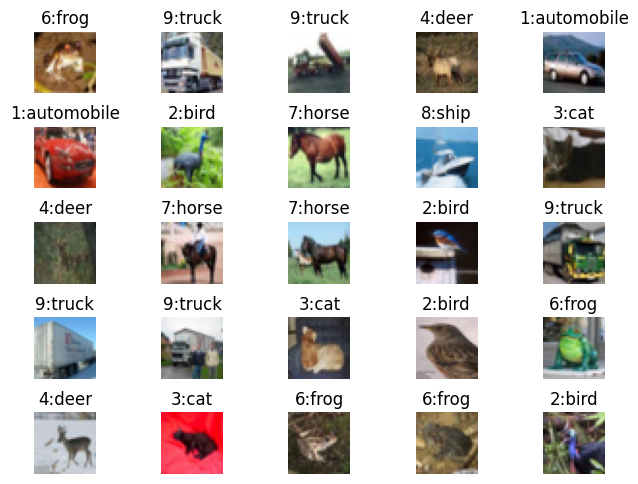

In [3]:
# don't need to edit anything here,
# just run this cell

# get dataset
from tensorflow.keras.datasets import cifar10
# get common libraries
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # this is a new one: makes loading bars

def get_data_subset(n_train, n_test):
    (train_X, train_y), (test_X, test_y) = cifar10.load_data()
    train_X, train_y, test_X, test_y = train_X[:n_train], train_y[:n_train], test_X[:n_test], test_y[:n_test]
    train_y, test_y = train_y.squeeze(), test_y.squeeze()
    return train_X, train_y, test_X, test_y

n_train, n_test = 1000, 1000

train_X, train_y, test_X, test_y = get_data_subset(n_train, n_test)

fig, axs = plt.subplots(5,5)
axs = axs.flatten()
fig.tight_layout(pad=0.3)

class_labels = {0:"airplane",
                1:"automobile",
                2:"bird",
                3:"cat",
                4:"deer",
                5:"dog",
                6:"frog",
                7:"horse",
                8:"ship",
                9:"truck"}

for i, ax in enumerate(axs):
    ax.imshow(train_X[i])
    ax.set_title(f"{train_y[i]}:{class_labels[train_y[i]]}")
    ax.axis("off")

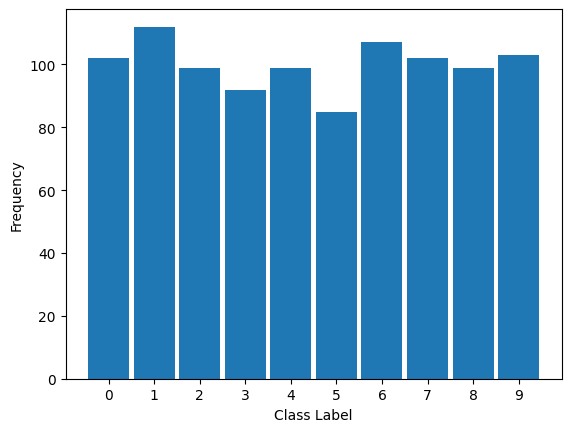

In [4]:
# making sure the quantity of examples for each label are about the same
plt.hist(train_y, bins=10, rwidth=0.9)
plt.xticks(0.9*np.arange(10)+0.45, range(10))
plt.ylabel("Frequency")
plt.xlabel("Class Label")
plt.show()

## Question 2.1 -- Preprocessing

The first thing we should do is preprocess the images so that they are ready to be input into our models. First, print out the shape of the dataset's inputs (`train_X`).

In [5]:
print(train_X.shape)

(1000, 32, 32, 3)


**Q 2.1.1** What does each value in the tuple that was printed out mean?

1000 - nr of samples
32 - number of horizontal pixels
32 - number of vertical pixels
3 - number of colors (red, green, blue)

**Q 2.1.2** Next, flatten the pixel values to a single vector. What is the length of this vector? Print out the shape of the flattened dataset's inputs once more.

In [6]:
# Your answer here
def flatten_cifar10(samples):
    return samples.reshape(samples.shape[0], -1)

train_X, test_X = flatten_cifar10(train_X), flatten_cifar10(test_X)
print(train_X.shape)
print(test_X.shape)

(1000, 3072)
(1000, 3072)


## Question 3 -- Model Selection using Grid Search

In the lecture, we have seen four different ML classification algorithms: logistic regression, decision trees, random forests and support vector machines. In this assignment, we will figure out which is best, and a basic method to figure out the best way to tune the parameters of each one. Remember, a hyperparameter is something that you choose by hand about the model or the way it trains.

### Question 3.1 -- Logistic regression

Use `sklearn` (as in the lecture notebook) to classify the CIFAR10 sub-dataset. There are not a lot of major hyperparameters to tune here, so this exercise should be straightforward. Create a LogisticRegression object, fit it on the training data, and compute the train and test accuracies.

*Expected runtime: ~1min*

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

modelLR = LogisticRegression()
modelLR = modelLR.fit(train_X,train_y)
pred_tr = modelLR.predict(train_X)
pred_te = modelLR.predict(test_X)

def accuracy_score(pred,true):
  count = 0
  for tr, te in zip(pred,true):
    if tr == te:
      count+=1
  return count/len(pred)

print("Training score:", accuracy_score(modelLR.predict(train_X), train_y))
print("Testing score: ", accuracy_score(modelLR.predict(test_X), test_y))

Training score: 0.948
Testing score:  0.257


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Q 3.1.2** Does the model work well in your opinion? What about whether it is over/underfitting?

Model is not working well. Train accuracy is high, test accuracy low, Hence it is overfitting

### Question 3.2 -- Decision Trees

Decision trees have one main hyperparameter that you can tune -- this is the maximum depth of the tree being trained. Thus, we'll try and figure out what depth is the optimal for our purposes.

An important thing to note is that decision trees are randomized initially -- this means that two trees of the same depth may have wildly different performances, depending on how they were initialized.

**Q 3.2.1** Loop over max tree depths from $d=1$ to $d=15$ and store the mean and standard deviation of train and test scores for 10 randomly initialised trees.

*Expected runtime: <5 mins*

In [8]:
from sklearn import tree

train_acc_mean, train_acc_std = [], [] # to store the training accuracies
test_acc_mean, test_acc_std = [], []   # to store the testing accuracies

for d in tqdm(range(15)):
    train_perfs = []
    test_perfs = []
    for n in range(10):
        modelDT = tree.DecisionTreeClassifier(max_depth = d+1)
        modelDT = modelDT.fit(train_X,train_y)
        train_perfs.append(accuracy_score(modelDT.predict(train_X), train_y))
        test_perfs.append(accuracy_score(modelDT.predict(test_X), test_y))


    train_acc_mean.append(np.mean(train_perfs))
    train_acc_std.append(np.std(train_perfs))
    test_acc_mean.append(np.mean(test_perfs))
    test_acc_std.append(np.std(test_perfs))


100%|██████████| 15/15 [06:00<00:00, 24.07s/it]


**Q 3.2.2** Plot the test and train means with errorbars equal to one standard deviation (look at [plt.errorbar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html) for reference). Don't forget to add labels.

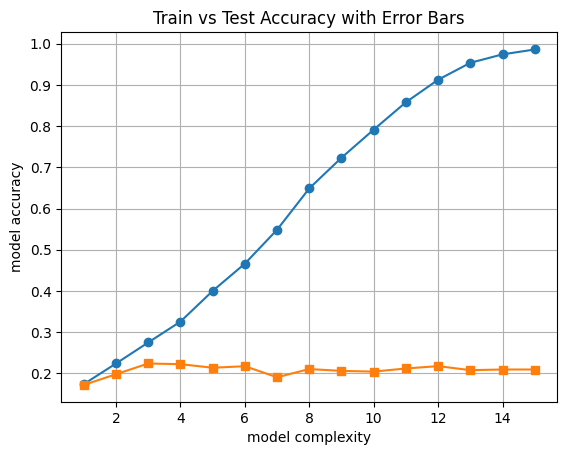

In [9]:
plt.errorbar(np.arange(1,16), train_acc_mean, yerr=train_acc_std, label="Train", fmt='-o')
plt.errorbar(np.arange(1,16), test_acc_mean, yerr=test_acc_std, label="Test", fmt='-s')
plt.title("Train vs Test Accuracy with Error Bars")
plt.ylabel("model accuracy")
plt.xlabel("model complexity")
plt.grid()
plt.show()

**Q 3.2.3**

1. Is there a lot of variation of the performance of the trees (enough to question statistical significance)?

2. Which model (of the ones you tested) performed best on the training set? Which performed best on the test set?

3. At what depth do models start to overfit the training data?


1. No, the error bars are not even visible on the plot

2. Decision tree works best on training set. Accuracy beats logistic regression after having depth of 13 or more. Logistic regression works best on test set. Accuracy beats decision tree for all depths.


3. This decision tree already starts overfitting after depth of 3

## Question 3.3 -- Random Forests
Just like in the decision trees, one hyperparameter you can choose is the depth of the tree. However, another important one is the number of decision trees. In this case, the performance is affected by the combination of these hyperparameters, and so we need to train and evaluate them at each combination.

**Q 3.3.1** Loop over $n_{trees}=10$ to $n_{trees}=100$ in increments of 10, and max tree depths from $d\in[1,3,5,7,9,11,13,15]$ and store the mean and standard deviation of train and test scores for 5 randomly initialised trees.

*Expected runtime: ~9 minutes*

In [10]:
from sklearn.ensemble import RandomForestClassifier as RFC

train_acc_mean, train_acc_std = np.zeros((10, 8)), np.zeros((10, 8)) # storing it in an np array instead of a list makes it easier
test_acc_mean, test_acc_std =np.zeros((10, 8)), np.zeros((10, 8))

n_trees = [10,20,30,40,50,60,70,80,90,100]
depths = [1,3,5,7,9,11,13,15]

for tree_idx, n_trees in tqdm(enumerate(n_trees), total=len(n_trees)):
    for d_idx, d in enumerate(depths):
        train_perfs = []
        test_perfs = []
        for n in range(5):
          modelRFC = RFC(n_trees, max_depth = d)
          modelRFC = modelRFC.fit(train_X, train_y)
          train_perfs.append(accuracy_score(modelRFC.predict(train_X), train_y))
          test_perfs.append(accuracy_score(modelRFC.predict(test_X), test_y))

        train_acc_mean[tree_idx][d_idx] = np.mean(train_perfs)
        train_acc_std[tree_idx][d_idx] = np.std(train_perfs)
        test_acc_mean[tree_idx][d_idx] = np.mean(test_perfs)
        test_acc_std[tree_idx][d_idx] = np.std(test_perfs)

100%|██████████| 10/10 [12:31<00:00, 75.18s/it] 


Looping over several variables and testing each combination is called a **grid search**. Since we have two hyperparameters, we cannot plot a 1D line to see which is best, as we did for normal DTs. One way to visualize this instead is a heatmap. For this, we can `seaborn`'s [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function.  

**Q 3.3.2** Plot two heatmaps: one for the train accuracies and one for the test ones.

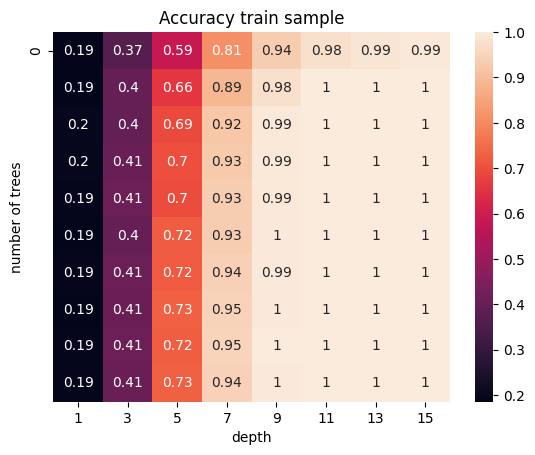

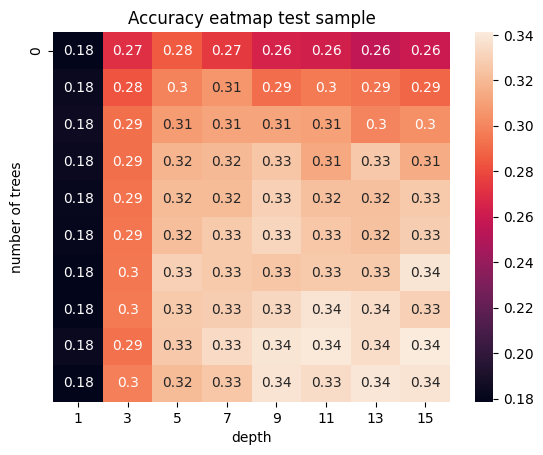

In [12]:
import seaborn as sns
# Figure 1
plt.figure()
sns.heatmap(train_acc_mean, annot=True, xticklabels = depths, yticklabels = n_trees)
plt.xlabel("depth")
plt.ylabel("number of trees")
plt.title("Accuracy train sample")
plt.show()

# Figure 2
plt.figure()
sns.heatmap(test_acc_mean, annot=True, xticklabels = depths, yticklabels = n_trees) # create seaborn heatmap with annotations
plt.xlabel("depth")
plt.ylabel("number of trees")
plt.title("Accuracy eatmap test sample")

plt.show()

**Q 3.3.2**
1. What trends with respect to each hyperparameter do the heatmaps show you?
2. What model performs best on the train set? What model performs best on the test set?
3. What model would you choose to deploy and why?

1. increasing depth and number of trees causes increase in accuracy.
increasing number of trees causes a greater increase in accuracy than increasing tree depth

2. Random forest performs best on both train and test set

3. Random forest. It has highest test accuracy. depth = 5+ and number of trees = 50+

## Question 3.4 -- Support Vector Machines

`sklearn`'s SVM classifier implementation (called "SVC", we already met them in the lecture) contains quite a number of hyperparameters you can tune. The ones we are looking at today are the kernel, the parameter `C` (which is some penalty term for incorrectly classifying a data point, applicable to the RBF kernel), `gamma`, which is a measure of how important closer points to the decision boundary are with respect to the decision boundary (applicable to the RBF kernel), and `degree`, which is the degree of the polynomial function (applicable to the poly kernel). Let $C\in\{0.1, 1, 10, 100\}$ and $gamma\in\{10^x|-2\leq x\leq 2, x\in\mathbb{Z}\}$. Let us use $degree\in\{2,3,4\}$.

A note about the kernel: In short, this is a function that determines what the shape of the decision boundary are. The choices that we can check out here (there are more) are `linear` (linear decision boundary), `poly` (polynomial) and `rbf` (radial basis function) in order of flexibility.

Since we are trying to optimize for a number of different parameters, writing out all the code ourselves gets a bit messy. Instead, we use `sklearn` again! The class in question is called `GridSearchCV`, which performs a grid search over parameters with specified values.

The 'CV' part of the name refers to the fact that we are performing *cross-validation*, which is related to the concept of validation sets that we encountered last week. We will cover it in a future lecture, but for now, the way it works is that it splits the training set into $k$ sets (called 'folds') and iteratively trains on $k-1$ folds and validates on the remaining one. The result is the mean over $k$ iterations. CV is considered the 'gold standard' with respect to analysing model robustness. We will use $k=5$ (appropriately called *5-fold cross-validation*), which is standard for a first analysis.

**Q 3.4.1** Run a gridsearch with 5-fold cross-validation over the hyperparameters discussed above to find an optimal SVC model. Please look at GridSearchCV's documentation for more information.

*Expected runtime: Around 15 minutes if you're lucky.*

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid_svm = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10, 100]},
    {'kernel': ['poly'], 'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4], 'gamma': [0.01, 0.1, 1, 10, 100]},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10, 100]}
]

# create the cross-validation object
optimal_params_svm = GridSearchCV(
    estimator = SVC(),
    param_grid = param_grid_svm,
    cv = 5,
    scoring='accuracy',
)

optimal_params_svm.fit(train_X, train_y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (optimal_params_svm.best_params_, optimal_params_svm.best_score_)
)

NameError: name 'train_X' is not defined

**Q 3.4.2**
1. How many combinations of parameters are there? Why?
2. Using 5-fold validation, how many models do you train in total?

1. 84
2. 5

I could not finish rest of assignment due to the long runtime of svm. (I had 3 runs with over 1 hr runtime)

**Q 3.4.3**
Create a model `modelSVC` with the optimal parameters you found above and print out the train and test accuracies.

In [ ]:
modelSVC = SVC(kernel = 'rbf', C = 1, gamma = 0) # create model
modelSVC = modelSVC.fit(train_X, train_y)      # train model
print("Training score:", accuracy_score(modelSVC.predict(train_X), train_y))
print("Testing score: ", accuracy_score(modelSVC.predict(test_X), test_y))

## Question 4 -- Training and inference speed
Depending on the application, the choice of model may be affected by more than just the raw score. One of these factors is *time* -- specifically, how long does the model take to train, and how long does it take to make a prediction. In this case we're increasing the number of training points to 5000.
When analyzing the training and inference speed of machine learning models, it is crucial to measure how long a model takes to:

1. Train (Fit): The time required to learn from the training dataset.
2. Infer (Predict): The time required to classify a new image (for image classification) or make a prediction on new data.

The perf_counter() function is useful for this because it provides high-precision timing measurements, making it ideal for benchmarking models.

**Q 4.1** Create models with the  that you found above, measure how long it takes for it to train and classify images from the test and train set, along with their accuracies (a classification, or a single run of a model, is generally called an 'inference'). We generally store time with an action taken (fit or inference) *per image* and the inference times *per image*.

*Runtime: ~3mins*



In [ ]:
from time import perf_counter # used to compute intervals

n_train, n_test = ..., ...
... = get_data_subset(...) # get data
... # flatten images

# set up lists to store scores and times
train_scores = []
test_scores = []
fit_times = []
inf_times = []

def train_and_eval(model, train_X, train_y, test_X, test_y):
    """ Trains, times and evaluates a given instantiated model on data """

    start = perf_counter()               # check current (start) time
    model = model.fit(...)               # perform some code that you want to time
    end = perf_counter()                 # check current (end) time
    fit_time = end-start                 # compute interval

    # time inference over train score
    start = perf_counter()
    train_score = ...
    end = perf_counter()
    train_score_time = end-start

    # time inference over test score
    start = perf_counter()
    test_score = ...
    end = perf_counter()
    test_score_time = end-start

    return train_score, test_score, fit_time, train_score_time, test_score_time

# create models
modelLR = ...
modelDT = ...
modelRFC = ...
modelSVC = ...

for model in tqdm([modelLR, modelDT, modelRFC, modelSVC]):
    train_score, test_score, fit_time, train_score_time, test_score_time = train_and_eval(model, train_X, train_y, test_X, test_y)
    # add these values to the list set up above
    # don't forget that the training and inference times should be stored per image and not for the whole run
    ...

Plot two barplots:
1. **Q 4.2** On one, plot a dual barplot showing the test and train accuracies.
2. **Q 4.3** On the other, plot a double barplot showing the training time *per image* and the inference times *per image* (so divide the total time by the number of images).

For each, make sure you don't forget the unit of measurement, add a title and axis labels and make sure there are labels and a legend.

In [ ]:
model_names = [...]
bar_width = 0.35

# Create an array for the x-axis positions
x = np.arange(...)

# Plotting the bars
fig, ax = plt.subplots()
bar1 = ax.bar(...) # training accuracy: don't forget to add labels
bar2 = ax.bar(...) # testing accuracy

# Add labels, title, and legend
ax.set_xlabel(...)
ax.set_ylabel(...)
ax.set_title(...)

# set proper x ticks: I'll help you with this one
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(model_names)
ax.legend()

In [ ]:
# Plotting the times
fig, ax = plt.subplots()
bar1 = ax.bar(...) # fit times: don't forget labels
bar2 = ax.bar(...) # inference times

# Add labels, title, and legend
# set proper x ticks

**Q 4.4**
1. What model is the fastest to train?
2. What model is fastest to infer?
3. What model has the highest train accuracies? What model has the highest test accuracies?
4. What model would you choose to use? Why?

*Your answer here*